In [1]:
# For google colab
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=c739030ed5b82d70e38bd41fd21211f50812c08e2892c7941cd875427b73b75c
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 157.3 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [1]:
# For google colab
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [0]:
# For google colab
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/image_to_image/')

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import models
import data
import utils
from torchvision import transforms

cuda = torch.cuda.is_available()


In [16]:
import argparse

# Hyperparameters

parser = argparse.ArgumentParser()

parser.add_argument("--in_channels",      type=int,   default=3,   help="number of channels on input")
parser.add_argument("--out_channels",     type=int,   default=3,   help="number of channels on output")

parser.add_argument("--unet_depth",       type=int,   default=7,   
                    help="number of downsamplings on unet: image shape should equal [2^depth, 2^depth]")
parser.add_argument("--unet_out_f",       type=int,   default=64,  help="n of filters in the last conv layer of unet")
parser.add_argument("--unet_conv_kernel", type=int,   default=4,   help="kernel size on unet conv layers")
parser.add_argument("--unet_conv_stride", type=int,   default=2,   help="stride on unet conv layers")
parser.add_argument("--unet_conv_pad",    type=int,   default=1,   help="padding on unet conv layers")
parser.add_argument("--unet_dropout",     type=float, default=0.5, help="dropout rate on unet")
parser.add_argument("--unet_lrelu_slope", type=float, default=0.2, help="slope of leaky relu on unet")

parser.add_argument("--lr", type=float, default=0.0002, help='initial learning rate')
parser.add_argument("--beta1", type=float, default=0.5, help='first momentum term')
parser.add_argument("--beta2", type=float, default=0.999, help='second momentum term')
parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 loss')

parser.add_argument('--n_epochs', type=int, default=200, help='number of epochs')

parser.add_argument('-f', '--file', help='Path for input file. First line should contain number of lines to search in')

hps = parser.parse_args()

In [17]:
def imshow(img, title=''):
    """Plot the image batch.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

In [18]:
import matplotlib.pyplot as plt
import data_set
#generator = data.DummyGenerator()
#X, Y = generator.generate_rectangles()

#dataset = data.CustomTensorDataset(tensors=(X, Y))
width = 512
height = 512
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(
        (height, width), pad_if_needed=True, padding_mode='constant'),
    transforms.ToTensor()
])
dataset = data_set.EdgeDataset('./db/captioned_urls.csv', transform=transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=8, collate_fn=data_set.collate_fn)

In [19]:
ImgToImg = models.ImageToImage(hps)

In [20]:
ImgToImg.D

Discriminator(
  (net): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [21]:
# Test forward pass with upsampled dummy data

from torch.autograd import Variable

u = torch.nn.Upsample(scale_factor=4)

x, _ = dataset[0]
x = x.unsqueeze(0)
x = Variable(x)
if cuda:
    x = x.cuda()
x = u(x)

hat_y = ImgToImg.G(x)

x = x.squeeze(0).cpu()
plt.imshow(x.permute(1, 2, 0))


ValueError: too many values to unpack (expected 2)

In [22]:
hat_y = hat_y.squeeze(0).detach().cpu()
plt.imshow(hat_y.permute(1, 2, 0))

NameError: name 'hat_y' is not defined

In [23]:
# Test forward pass with upsampled dummy data

from torch.autograd import Variable

u = torch.nn.Upsample(scale_factor=4)

x, y = dataset[0]
xy = torch.cat((x, y), dim=0)
if cuda:
    xy = xy.cuda()
xy = xy.unsqueeze(0)
xy = Variable(xy)
xy = u(xy)

xy = ImgToImg.D(xy)
xy.shape


ValueError: too many values to unpack (expected 2)

In [24]:
x = x.unsqueeze(0)
hat_y = hat_y.unsqueeze(0)

x = u(x)

hat_xy = torch.cat((x, hat_y), dim=1)
hat_xy = Variable(hat_xy)

if cuda:
    hat_xy = hat_xy.cuda()

hat_xy = ImgToImg.D(hat_xy)
hat_xy.shape

NameError: name 'x' is not defined

In [25]:
if cuda:
    ImgToImg = nn.DataParallel(ImgToImg).cuda()


load = True

if cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

if load:
    ImgToImg.load_state_dict(torch.load('./results/ImgToImg_all_type_of_images.pth', map_location=device))
    ImgToImg.to(device)
    ImgToImg.train()

In [26]:
import time
import torchvision

# Google colab version

if False:

    for epoch in range(hps.n_epochs):

        for i, (x, y) in enumerate(loader):

            t = time.time()

            # Upsample
            x = u(x).cuda()
            y = u(y).cuda()
            ImgToImg.module.optimize_parameters(x, y)

            loss_G = ImgToImg.module.loss_G
            loss_D = ImgToImg.module.loss_D

            print('Batch: {}, iteration took {:.4f}, Loss_G: {}, Loss_D: {}'.format(i, time.time() - t, loss_G, loss_D))

            if (i + 1) % 1 == 0:
                # Save real input
                grid = torchvision.utils.make_grid(x)
                torchvision.utils.save_image(grid, '/content/gdrive/My Drive/Colab Notebooks/image_to_image/images1/dummy_test_{}_real_X.png'.format(epoch))

                # Save real output
                grid = torchvision.utils.make_grid(y)
                torchvision.utils.save_image(grid, '/content/gdrive/My Drive/Colab Notebooks//image_to_image/images1/dummy_test_{}_real_Y.png'.format(epoch))

                # Save fake output
                hat_y = ImgToImg.module.G(x)
                grid = torchvision.utils.make_grid(hat_y)
                torchvision.utils.save_image(grid, '/content/gdrive/My Drive/Colab Notebooks//image_to_image/images1/dummy_test_{}_fake_Y.png'.format(epoch))

# CPU
                
else:
    
    for epoch in range(hps.n_epochs):

        for i, (x, y) in enumerate(loader):

            t = time.time()

            # Upsample
            if cuda:
                x = x.cuda()
                y = y.cuda()
            #x = u(x)
            #y = u(y)
            ImgToImg.module.optimize_parameters(x, y)

            loss_G = ImgToImg.module.loss_G
            loss_D = ImgToImg.module.loss_D

            print('Batch: {}, iteration took {:.4f}, Loss_G: {}, Loss_D: {}'.format(i, time.time() - t, loss_G, loss_D))

            if (i + 1) % 1 == 0:
                # Save real input
                grid = torchvision.utils.make_grid(x)
                torchvision.utils.save_image(grid, './results/dummy_test_{}_real_X.png'.format(epoch))

                # Save real output
                grid = torchvision.utils.make_grid(y)
                torchvision.utils.save_image(grid, './results/dummy_test_{}_real_Y.png'.format(epoch))

                # Save fake output
                hat_y = ImgToImg.module.G(x)
                grid = torchvision.utils.make_grid(hat_y)
                torchvision.utils.save_image(grid, './results/dummy_test_{}_fake_Y.png'.format(epoch))

...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0

KeyboardInterrupt: 

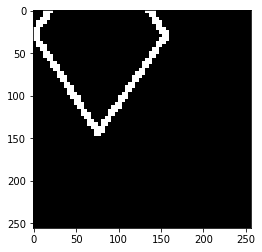

In [0]:
x, _ = dataset[0]
x = x.unsqueeze(0)
x = Variable(x)
x = u(x)

hat_y = ImgToImg.G(x)
x = x.squeeze(0)
plt.imshow(x.permute(1, 2, 0))

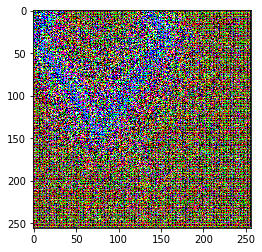

In [0]:
hat_y = hat_y.squeeze(0).detach()
plt.imshow(hat_y.permute(1, 2, 0))

In [27]:
torch.save(ImgToImg.state_dict(), './results/ImgToImg_all_types_of_images_2.pth')